# EM206 Final Project
## Occupation, Salary and Likelihood of Automation  

### 1. Import Packages & Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
salary_path = 'occupation_salary.xlsx'
salary_data = pd.read_excel(salary_path)
automation_path = 'automation_data_by_state.csv'
auto_data = pd.read_csv(automation_path, encoding = 'ISO-8859-1')

Compared to the number of workers in each state, we are more interested in the population proportion of each occupation in states. Therefore, we need the US population data by states.

In [3]:
link = 'https://www.infoplease.com/us/states/state-population-by-rank'
w = pd.read_html(link, header=0)
population_data = w[0]
population_data.columns

Index(['Rank', 'State', 'July 2019 Estimate', 'Percent of Total'], dtype='object')

In [4]:
# Rename the last two column
population_data = population_data.rename({'July 2019 Estimate':'Estimate',
                                          'Percent of Total':'Total'},
                                         axis=1)

### 2. Data Preperation

#### 2.1. Salary

In [5]:
salary_data.head()

,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,H_MEAN,A_MEAN,MEAN_PRSE,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,00-0000,All Occupations,total,140400040,0.1,23.86,49630,0.1,9.27,11.6,17.81,28.92,45.45,19290,24140,37040,60150,94540,NaN,NaN
1,11-0000,Management Occupations,major,7090790,0.2,56.74,118020,0.1,22.76,32.99,48.46,70.72,#,47330,68630,100790,147090,#,NaN,NaN
2,11-1000,Top Executives,minor,2465800,0.2,61.03,126950,0.2,20.58,31.45,49.19,78.35,#,42810,65420,102320,162970,#,NaN,NaN
3,11-1010,Chief Executives,broad,223260,0.7,93.44,194350,0.4,33.55,54.86,87.12,#,#,69780,114100,181210,#,#,NaN,NaN
4,11-1011,Chief Executives,detailed,223260,0.7,93.44,194350,0.4,33.55,54.86,87.12,#,#,69780,114100,181210,#,#,NaN,NaN


In [6]:
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394 entries, 0 to 1393
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OCC_CODE   1394 non-null   object 
 1   OCC_TITLE  1394 non-null   object 
 2   OCC_GROUP  1394 non-null   object 
 3   TOT_EMP    1394 non-null   int64  
 4   EMP_PRSE   1394 non-null   float64
 5   H_MEAN     1394 non-null   object 
 6   A_MEAN     1394 non-null   object 
 7   MEAN_PRSE  1394 non-null   float64
 8   H_PCT10    1394 non-null   object 
 9   H_PCT25    1394 non-null   object 
 10  H_MEDIAN   1394 non-null   object 
 11  H_PCT75    1394 non-null   object 
 12  H_PCT90    1394 non-null   object 
 13  A_PCT10    1394 non-null   object 
 14  A_PCT25    1394 non-null   object 
 15  A_MEDIAN   1394 non-null   object 
 16  A_PCT75    1394 non-null   object 
 17  A_PCT90    1394 non-null   object 
 18  ANNUAL     82 non-null     object 
 19  HOURLY     6 non-null      object 
dtypes: float

**OCC_GROUP** - The category of the size of the group. Total > Major > Minor > Broad > Detailed  
**EMP_PRSE** - Employment Relative Standard Error  
**H_MEAN** - Mean hourly wage  
**A_MEAN** - Mean annual wage  
**MEAN_PRSE** - Mean wage Relative Standard Error  
**H_PCT_10** - Hourly wage 10 percentile  
**H_PCT_25** - Hourly wage 25 percentile  
etc..

From the data table information, we can see that the automation data table has no missing values. However, the 'ANNUAL' and 'HOURLY' attributes in the salary table have separately 1312 and 1318 missing values. Given that the salary table has 1394 observations in total, we can simply drop these 2 columns.

In [7]:
salary_data = salary_data.drop(['ANNUAL','HOURLY'],axis=1)

Some numeric numbers are stored as the object type in the Salary table. The reason is that the Salary table has hashtags and star signs in some columns.

In [8]:
print("The number of observations with hashtags or starsigns: ",
      len(salary_data[salary_data.iloc[:,3:].isin(['#','*']).any(axis=1)]))

The number of observations with hashtags or starsigns:  134


134 observations in the Salary table have at least one hashtag or star sign. Given that the Salary table has a total of 1394 observations, 134 is small. We can filter out these 134 observations. Also convert the object-type values into numerics.

In [9]:
salary_data = salary_data[~salary_data.iloc[:,3:].isin(['#','*']).any(axis=1)].reset_index(drop=True)
for col in salary_data.columns[3:]:
    salary_data[col] = salary_data[col].astype(float)

PRSE values are unrelated to the project, we can simply drop them.

In [10]:
salary_data = salary_data.drop(['EMP_PRSE','MEAN_PRSE'],axis=1)
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OCC_CODE   1260 non-null   object 
 1   OCC_TITLE  1260 non-null   object 
 2   OCC_GROUP  1260 non-null   object 
 3   TOT_EMP    1260 non-null   float64
 4   H_MEAN     1260 non-null   float64
 5   A_MEAN     1260 non-null   float64
 6   H_PCT10    1260 non-null   float64
 7   H_PCT25    1260 non-null   float64
 8   H_MEDIAN   1260 non-null   float64
 9   H_PCT75    1260 non-null   float64
 10  H_PCT90    1260 non-null   float64
 11  A_PCT10    1260 non-null   float64
 12  A_PCT25    1260 non-null   float64
 13  A_MEDIAN   1260 non-null   float64
 14  A_PCT75    1260 non-null   float64
 15  A_PCT90    1260 non-null   float64
dtypes: float64(13), object(3)
memory usage: 157.6+ KB


#### 2.2 Automation

In [11]:
auto_data.head()

,SOC,Occupation,Probability,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,11-1011,Chief Executives,0.015,1030,760,5750,2710,31150,880,1410,...,560,5460,5890,3650,280,6320,5910,980,3740,160
1,11-1021,General and Operations Managers,0.160,26930,6490,43300,20680,261780,41540,33280,...,3730,44400,168610,36200,2760,52380,43760,10200,32350,4840
2,11-2011,Advertising and Promotions Managers,0.039,50,40,470,110,3760,480,300,...,0,670,1210,380,40,240,640,40,200,0
3,11-2021,Marketing Managers,0.014,530,200,4790,1090,33390,3060,4970,...,60,3400,9570,2320,380,3840,5830,260,2980,30
4,11-2022,Sales Managers,0.013,2510,400,10650,2650,69180,4570,7040,...,300,8890,22310,3360,480,5360,7390,600,5730,180


**Probability** - The probability of computerisation  
**Alabama** - The number of workers in Alabama  
etc..

Consider adding a new column of the total number of workers in the US. Also, filter out observations with all values in zero. 19 observations have all values in zero.

In [12]:
print("The number of observations with all values in zero: ",
      len(auto_data[(auto_data.iloc[:,3:]==0).all(axis=1)]))

The number of observations with all values in zero:  19


In [13]:
auto_data['total_workers'] = auto_data.iloc[:,3:].sum(axis=1)
auto_data = auto_data.loc[~(auto_data.iloc[:,3:]==0).all(axis=1)].reset_index(drop=True)
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SOC                   683 non-null    object 
 1   Occupation            683 non-null    object 
 2   Probability           683 non-null    float64
 3   Alabama               683 non-null    int64  
 4   Alaska                683 non-null    int64  
 5   Arizona               683 non-null    int64  
 6   Arkansas              683 non-null    int64  
 7   California            683 non-null    int64  
 8   Colorado              683 non-null    int64  
 9   Connecticut           683 non-null    int64  
 10  Delaware              683 non-null    int64  
 11  District of Columbia  683 non-null    int64  
 12  Florida               683 non-null    int64  
 13  Georgia               683 non-null    int64  
 14  Hawaii                683 non-null    int64  
 15  Idaho                 6

#### 2.3. Population by States

In [14]:
population_data.head()

,Rank,State,Estimate,Total
0,1.0,California,39512223,11.91%
1,2.0,Texas,28995881,8.74%
2,3.0,Florida,21477737,6.47%
3,4.0,New York,19453561,5.86%
4,5.0,Illinois,12671821,3.86%


In [15]:
population_data.tail()

,Rank,State,Estimate,Total
47,48.0,Alaska,731545,0.22%
48,49.0,DC,705749,0.21%
49,50.0,Vermont,623989,0.19%
50,51.0,Wyoming,578759,0.17%
51,NaN,Total U.S.,321418820,NaN


Instead of keeping the "Total U.S." row in the data table, we can simply drop the row and store the total population as a variable.

In [16]:
total_population = population_data.Estimate.get(key=51)
population_data = population_data.drop(51)

In [17]:
# Convert the data type of Rank into integer
population_data['Rank'] = population_data['Rank'].astype(int)

#### 2.4. Compatibility

Salary table and Automation table both have occupation code and occupation name.

In [18]:
auto_code = pd.unique(auto_data.SOC)
salary_code = pd.unique(salary_data.OCC_CODE)
intersect_code = np.intersect1d(auto_code,salary_code)
len(intersect_code)/len(auto_code)

0.9472913616398243

In [19]:
auto_name = pd.unique(auto_data.Occupation)
salary_name = pd.unique(salary_data.OCC_TITLE)
intersect_name = np.intersect1d(auto_name,salary_name)
len(intersect_name)/len(auto_name)

0.6603221083455344

94% of the occupation code in the automation tables are also in the salary table. Thus, we can join the two tables using occupation code. However, only 66% of the names in the automation table can also be found in the salary table. The reason is that the automation table uses semicolons instead of commas. Therefore, we can simply replace the semicolons with commas.

In [20]:
salary_name[np.char.find(list(salary_name),',')!=-1]

array(['Transportation, Storage, and Distribution Managers',
       'Farmers, Ranchers, and Other Agricultural Managers',
       'Education Administrators, Preschool and Childcare Center/Program',
       'Education Administrators, Postsecondary',
       'Education Administrators, All Other',
       'Property, Real Estate, and Community Association Managers',
       'Managers, All Other',
       'Agents and Business Managers of Artists, Performers, and Athletes',
       'Buyers and Purchasing Agents, Farm Products',
       'Wholesale and Retail Buyers, Except Farm Products',
       'Purchasing Agents, Except Wholesale, Retail, and Farm Products',
       'Claims Adjusters, Appraisers, Examiners, and Investigators',
       'Claims Adjusters, Examiners, and Investigators',
       'Insurance Appraisers, Auto Damage',
       'Meeting, Convention, and Event Planners',
       'Compensation, Benefits, and Job Analysis Specialists',
       'Business Operations Specialists, All Other',
       'Ta

In [21]:
auto_name[np.char.find(list(auto_name),';')!=-1]

array(['Transportation; Storage; and Distribution Managers',
       'Farmers; Ranchers; and Other Agricultural Managers',
       'Education Administrators; Preschool and Childcare Center/Program',
       'Education Administrators; Elementary and Secondary School',
       'Education Administrators; Postsecondary',
       'Property; Real Estate; and Community Association Managers',
       'Managers; All Other',
       'Agents and Business Managers of Artists; Performers; and Athletes',
       'Buyers and Purchasing Agents; Farm Products',
       'Wholesale and Retail Buyers; Except Farm Products',
       'Purchasing Agents; Except Wholesale; Retail; and Farm Products',
       'Claims Adjusters; Examiners; and Investigators',
       'Insurance Appraisers; Auto Damage',
       'Meeting; Convention; and Event Planners',
       'Compensation; Benefits; and Job Analysis Specialists',
       'Business Operations Specialists; All Other',
       'Tax Examiners and Collectors; and Revenue Agents'

In [22]:
auto_data['Occupation'] = auto_data['Occupation'].str.replace(';',',')

After the replacement, the intersection rate of occupation name grows up to 93%.

In [23]:
auto_name_new = pd.unique(auto_data.Occupation)
intersect_name_new = np.intersect1d(auto_name_new,salary_name)
len(intersect_name_new)/len(auto_name_new)

0.931185944363104

#### 2.5. Merging tables

We would like to see whether the automation table and the population table are compatible. That is, whether the state names in these two tables are the same.

In [24]:
popu_state = population_data.State.tolist()
auto_state = auto_data.columns.tolist()[3:-1]
intersect_state = np.intersect1d(popu_state,auto_state)
print("Different states in the population table: ", set(popu_state)-set(intersect_state))
print("Different states in the population table: ", set(auto_state)-set(intersect_state))

Different states in the population table:  {'DC'}
Different states in the population table:  {'District of Columbia'}


Only DC has different names in the two tables. We can replace the "District of Columbia" in the automation table with "DC".

In [25]:
auto_data = auto_data.rename({'District of Columbia':'DC'}, axis=1)

We than can calculate the population proportion of each occupation in states. Replace the number of workers with occupation workers population ratio.

In [26]:
auto_data_T = auto_data.melt(id_vars = ['SOC','Occupation','Probability','total_workers'])
ratio_data = auto_data_T.merge(population_data, left_on = 'variable', right_on = 'State')
ratio_data['popu_ratio'] = ratio_data.value/ratio_data.Estimate
auto_ratio_data = ratio_data.drop(['value','Rank','State','Estimate','Total'],axis=1)
auto_ratio_data = auto_ratio_data.pivot(index=['SOC','Occupation','Probability','total_workers'],
                                        columns='variable',
                                        values='popu_ratio').reset_index()

Also consider replacing the total number of workers with the population ration.

In [27]:
auto_ratio_data['total_workers'] = auto_ratio_data['total_workers']/total_population
auto_ratio_data.head()

variable,SOC,Occupation,Probability,total_workers,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,11-1011,Chief Executives,0.015,0.000695,0.000210,0.001039,0.000790,0.000898,0.000788,0.000153,...,0.000633,0.000799,0.000203,0.001139,0.000449,0.000740,0.000776,0.000547,0.000642,0.000276
1,11-1021,General and Operations Managers,0.160,0.006810,0.005492,0.008872,0.005949,0.006853,0.006625,0.007213,...,0.004216,0.006498,0.005815,0.011291,0.004423,0.006137,0.005747,0.005691,0.005556,0.008363
2,11-2011,Advertising and Promotions Managers,0.039,0.000087,0.000010,0.000055,0.000065,0.000036,0.000095,0.000083,...,0.000000,0.000098,0.000042,0.000119,0.000064,0.000028,0.000084,0.000022,0.000034,0.000000
3,11-2021,Marketing Managers,0.014,0.000641,0.000108,0.000273,0.000658,0.000361,0.000845,0.000531,...,0.000068,0.000498,0.000330,0.000724,0.000609,0.000450,0.000766,0.000145,0.000512,0.000052
4,11-2022,Sales Managers,0.013,0.001136,0.000512,0.000547,0.001463,0.000878,0.001751,0.000794,...,0.000339,0.001301,0.000769,0.001048,0.000769,0.000628,0.000970,0.000335,0.000984,0.000311


Only occupations in both the salary table and the automation table will be kept. Merge the two tables using occupation code. The merged table has 647 observations. Each observation is a occupation.

In [28]:
auto_clean = auto_ratio_data.loc[auto_ratio_data.SOC.isin(intersect_code)]
salary_clean = salary_data.loc[salary_data.OCC_CODE.isin(intersect_code)]
df = auto_clean.merge(salary_clean, left_on = 'SOC', right_on = 'OCC_CODE').drop(['OCC_CODE','OCC_TITLE'],1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 646
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SOC             647 non-null    object 
 1   Occupation      647 non-null    object 
 2   Probability     647 non-null    float64
 3   total_workers   647 non-null    float64
 4   Alabama         647 non-null    float64
 5   Alaska          647 non-null    float64
 6   Arizona         647 non-null    float64
 7   Arkansas        647 non-null    float64
 8   California      647 non-null    float64
 9   Colorado        647 non-null    float64
 10  Connecticut     647 non-null    float64
 11  DC              647 non-null    float64
 12  Delaware        647 non-null    float64
 13  Florida         647 non-null    float64
 14  Georgia         647 non-null    float64
 15  Hawaii          647 non-null    float64
 16  Idaho           647 non-null    float64
 17  Illinois        647 non-null    flo

In [29]:
df.Occupation.count()

647

According to the U.S. Bureau of Labor Statistics website, occupations have 22 major groups. These major groups can be identified by the occupation code, which is 'SOC' in the table df. We can add two column separately for the major group codes and the major group names.  
  
https://www.bls.gov/oes/current/oes_stru.htm

In [30]:
major_group_d = {'group_name':['Management', 'Business and Financial Operations',
                               'Computer and Mathematical', 'Architecture and Engineering',
                               'Life, Physical, and Social Science', 
                               'Community and Social Service', 'Legal', 
                               'Education Instruction and Library', 
                               'Arts, Design, Entertainment, Sports and Media', 
                               'Healthcare Practitioners and Technical', 'Healthcare Support', 
                               'Protective Service', 'Food Preparation and Serving Related', 
                               'Building and Grounds Cleaning and Maintenance', 
                               'Personal Care and Service', 'Sales and Related', 
                               'Office and Administrative Support', 
                               'Farming, Fishing, and Forestry', 'Construction and Extraction', 
                               'Installation, Maintenance and Repair', 'Production', 
                               'Transportation and Material Moving'], 
                 'group_code':['11', '13', '15', '17', '19', '21', '23', '25', '27', '29', '31', 
                               '33', '35', '37', '39', '41', '43', '45', '47', '49', '51', '53']}
major_group = pd.DataFrame(major_group_d)
df['group_code'] = df['SOC'].str.split('-',expand=True)[0]
df = df.merge(major_group, left_on='group_code',right_on='group_code')
df.head()

,SOC,Occupation,Probability,total_workers,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,group_code,group_name
0,11-2031,Public Relations and Fundraising Managers,0.015,0.000199,0.000082,0.000205,0.000170,0.000099,0.000177,0.000167,...,51.59,73.06,98.61,59070.0,78710.0,107320.0,151970.0,205110.0,11,Management
1,11-3011,Administrative Services Managers,0.730,0.000828,0.000131,0.000724,0.000944,0.000613,0.001031,0.000396,...,43.29,58.17,76.60,49270.0,66180.0,90050.0,120990.0,159330.0,11,Management
2,11-3051,Industrial Production Managers,0.030,0.000524,0.000634,0.000150,0.000348,0.000563,0.000484,0.000191,...,46.70,61.34,79.54,58610.0,74670.0,97140.0,127590.0,165450.0,11,Management
3,11-3061,Purchasing Managers,0.030,0.000219,0.000194,0.000178,0.000245,0.000169,0.000214,0.000132,...,53.65,68.67,85.37,63380.0,82880.0,111590.0,142820.0,177560.0,11,Management
4,11-3071,"Transportation, Storage, and Distribution Mana...",0.590,0.000352,0.000124,0.000752,0.000319,0.000427,0.000413,0.000203,...,42.88,56.39,73.43,52670.0,68140.0,89190.0,117300.0,152730.0,11,Management


**Field Description:**  
  
SOC - Occupation code  
Occupation - Occupation name  
Probability - The probability of computerization  
total_workers - Total population ratio in the U.S.  
Alabama and other states - Population ratio in each state  
OCC_GROUP - SOC Occupation level  
TOT_EMP - Estimated total employment  
H_MEAN - Mean hourly wage  
A_MEAN - Mean annual wage   
H_PCT_10 - Hourly wage 10 percentile  
group_code - Occupation major group code  
group_name - Occupation major group name

### 3. Exploratory Data Analysis

#### 3.1. Distribution of the probability of computerisation

In [31]:
print("The highest probability of computerisation is ",df.Probability.max())
print("The lowest probability of computerisation is ",df.Probability.min())

The highest probability of computerisation is  0.99
The lowest probability of computerisation is  0.0028


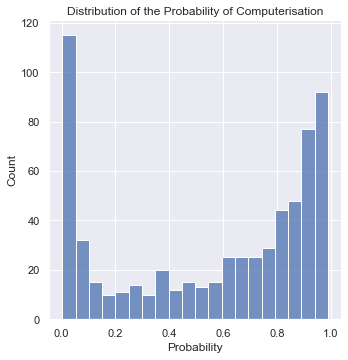

In [35]:
prob_plot = sns.displot(df,x="Probability",bins=20)
prob_plot.set(title="Distribution of the Probability of Computerisation")

The distribution of automation probability is very wide ranged, from 0.0028 to 0.99. According the graph of the distribution of probability, we see that most occupations have a very small probability of computation or very high probability of computation. Few occupations have the probability of automation of between 20% and 40%.

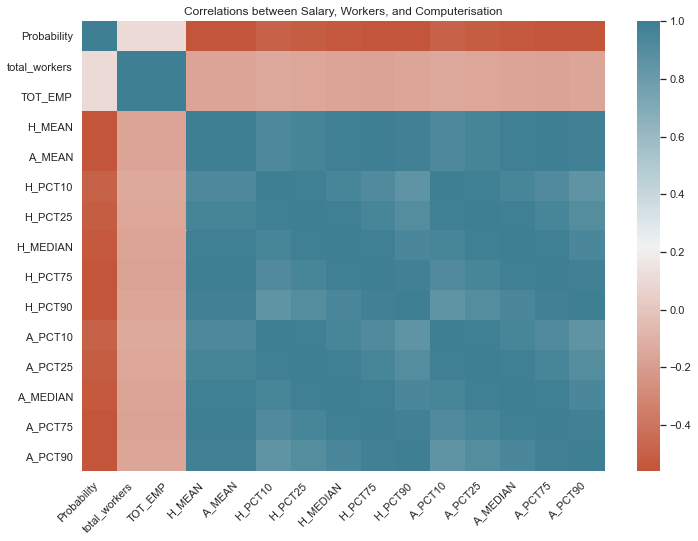

In [41]:
df_float = df[['Probability','total_workers','TOT_EMP','H_MEAN','A_MEAN','H_PCT10','H_PCT25',
               'H_MEDIAN','H_PCT75','H_PCT90','A_PCT10','A_PCT25','A_MEDIAN','A_PCT75','A_PCT90']]
ax = sns.heatmap(df_float.corr(),
                cmap = sns.diverging_palette(20,220,n=200))
ax.set_title("Correlations between Salary, Workers, and Computerisation")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The probability of computerisation is comparatively highly correlated with wage. Generally, occupations with lower probability of computerisation tend to have higher wages. On the other hand, the probability has weak correlation with the number of employees. To further confirm the correlation between probability of computerisation and the number of employees, we create another barplot.

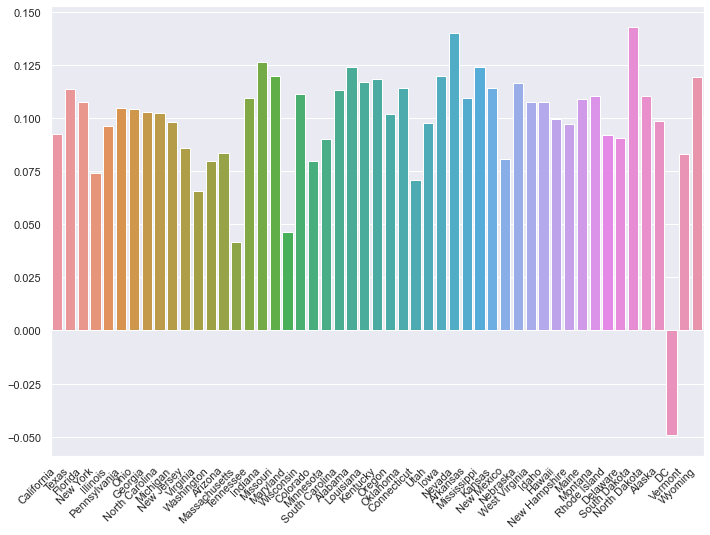

In [42]:
df_state = df[['Probability']+popu_state]
df_state_corr = df_state.corr().Probability[1:]
ax = sns.barplot(x=df_state_corr.index,y=df_state_corr.values)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From the above bar graph, we see that for each state, the correlation between probability and the population ratio is smaller than 0.15. Most of the states have a positive correlation, while DC has a negative and weak correlation, which is no lower than -0.05.

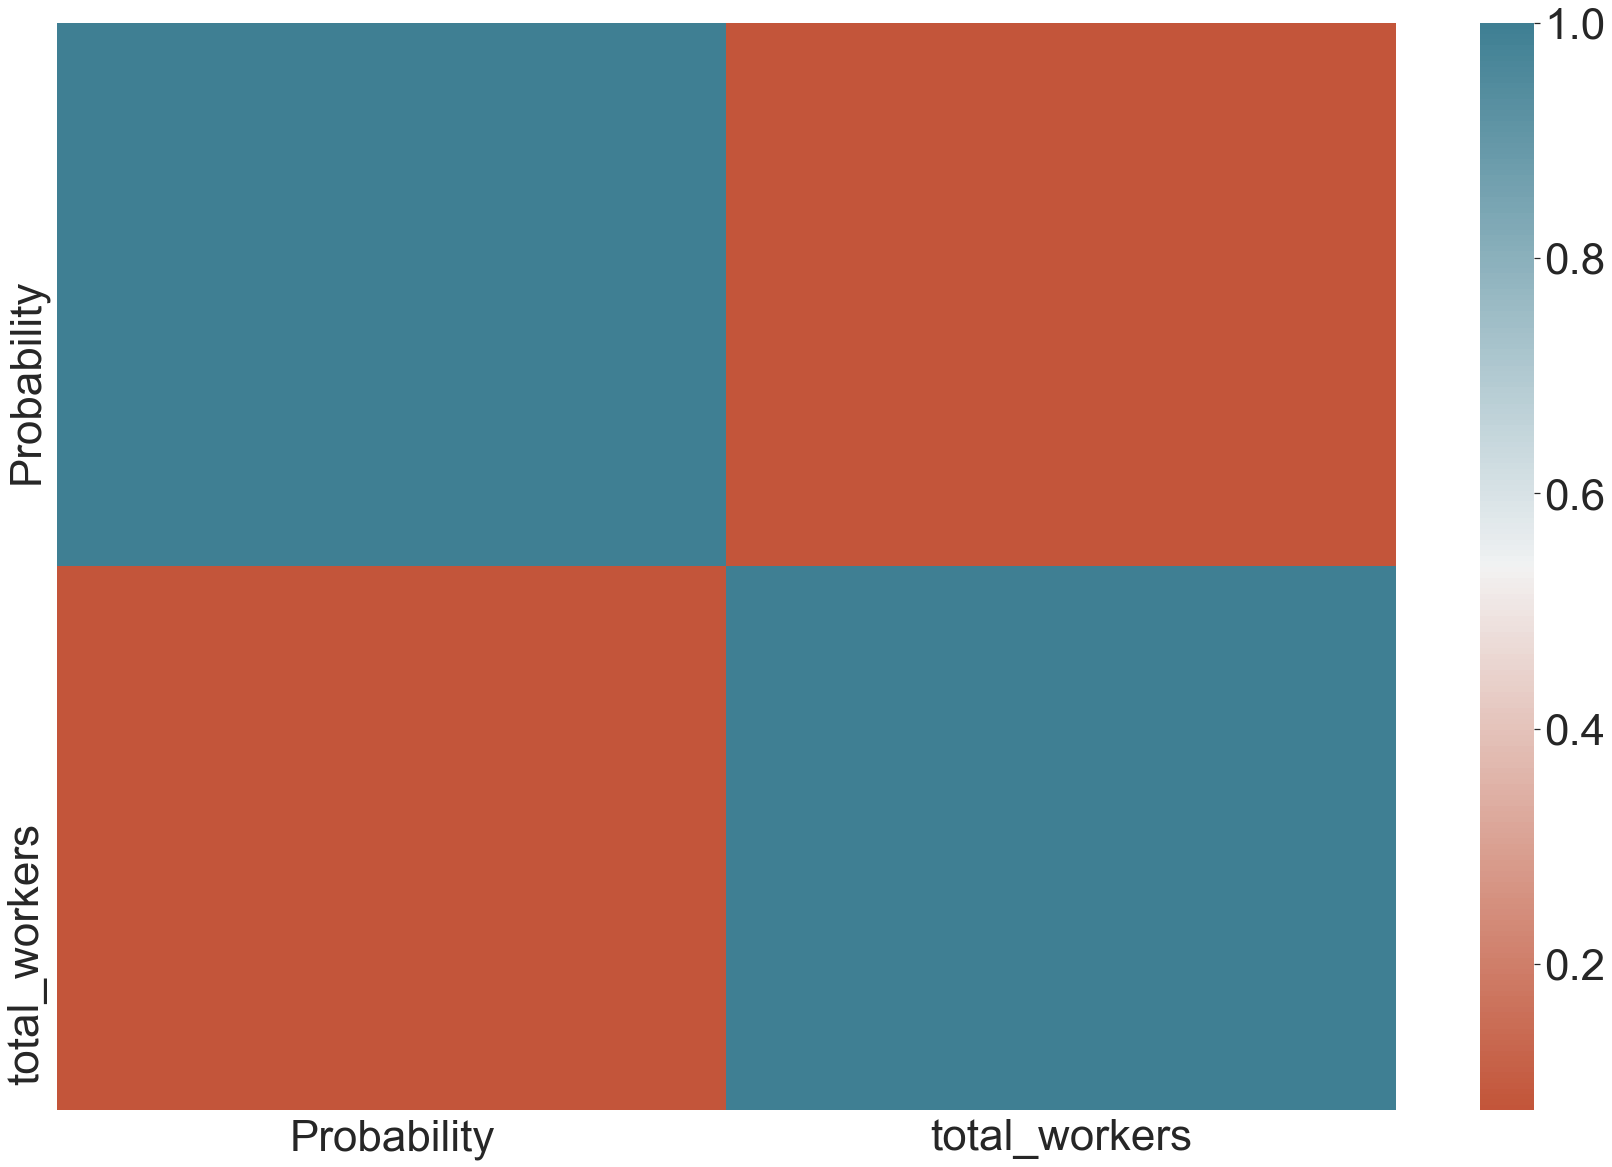

In [111]:
df_float2 = ratio_data[['Probability','total_workers','variable']]
sns.set_style("dark")

plt.figure(figsize=(30,20))
# plt.title("Occupations by US states")
sns.heatmap(df_float2.corr(),cmap = sns.diverging_palette(20,220,n=200)) 
# plt.xlabel("States")
plt.ylabel("")
sns.set(font_scale=4)
plt.savefig('All states Occupations groups and probability of automatisation.svg', bbox_inches="tight")
plt.show()

#### 3.2. Occupation groups

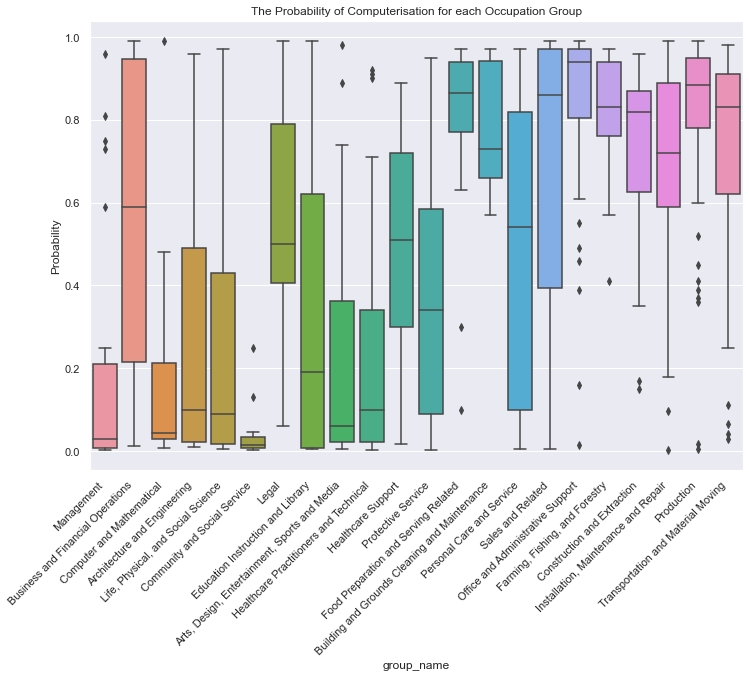

In [44]:
ax = sns.boxplot(data = df, x = "group_name", y = "Probability")
ax.set_title("The Probability of Computerisation for each Occupation Group")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The probability of automation for each occupation groups are highly diversed. Community and Social Service has a really low probability of automation. Management and Computer and Mathematical have a low probability as well. On the other hand, Office and Administrative Support has a high probability of automation, although with many outliers.  

### 4. PCA & KMeans Clustering

In [45]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [46]:
df_pca = df.select_dtypes(include='float')
std_occupation = StandardScaler().fit_transform(df_pca) # normalizing the data 
pca = PCA(n_components=0.99)
principalComponents = pca.fit_transform(std_occupation)

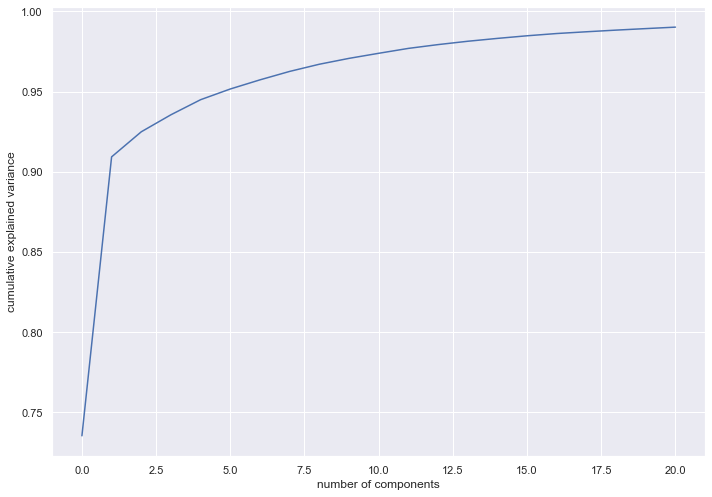

In [48]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.

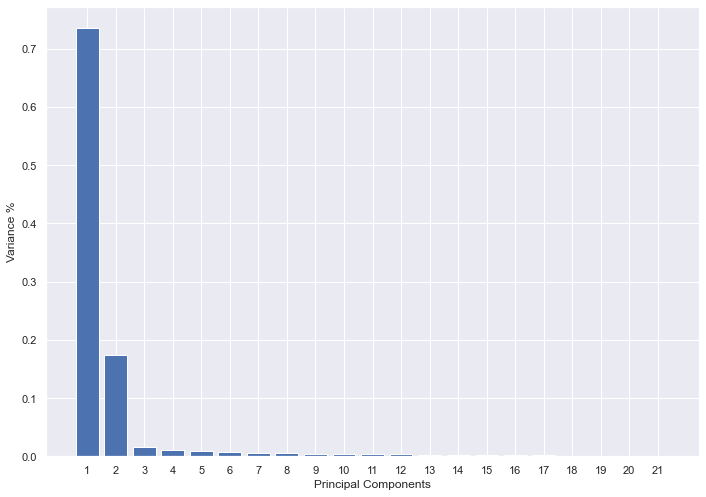

In [56]:
# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

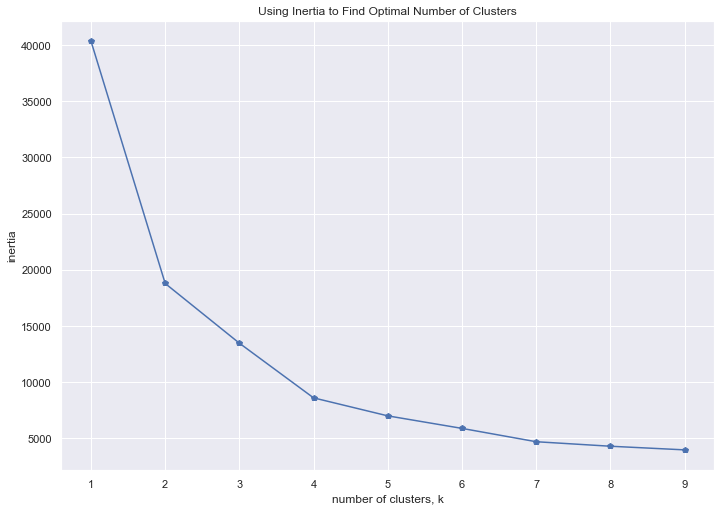

In [65]:
inertias = []

# Creating 10 K-Mean models while varying the number of clusters (k)
for k in range(1,10):
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:5])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(range(1,10), inertias, '-p')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')  # within-cluster sum of squares
plt.title('Using Inertia to Find Optimal Number of Clusters')
plt.show()

The graph above plots the inertia of each cluster as more clusters are added. Using this graph, we can see that the distance between each point in each cluster does not change much after 4 clusters. Therefore, we choose to analyse 4 clusters, giving us optimal seperation between each cluster while maintaining 4 distinct clusters.

In [74]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:5])
labels = model.predict(PCA_components.iloc[:,:5])

In [75]:
df['cluster']=labels
df2 = df.groupby(['group_name','cluster'])['group_name'].count().unstack('cluster').fillna(0).astype('int')
df2

cluster,0,1,2,3
group_name,,,,
Architecture and Engineering,11,0,0,22
"Arts, Design, Entertainment, Sports and Media",20,0,0,10
Building and Grounds Cleaning and Maintenance,5,1,2,0
Business and Financial Operations,8,0,2,18
Community and Social Service,13,0,0,0
Computer and Mathematical,1,0,0,11
Construction and Extraction,49,0,5,1
Education Instruction and Library,10,0,0,1
"Farming, Fishing, and Forestry",9,0,0,0


Using 4 clusters, we examine how each career category's data points fit in to each cluster. The table allows us to spot trends and outliers in the data for each category. For example, clusters 1 and 2 clearly contain much less points than clusters 0 and 3, showing that clusters 1 and 2 may contain more niche or outlier data points.

Text(0.5, 0, 'Career Category')

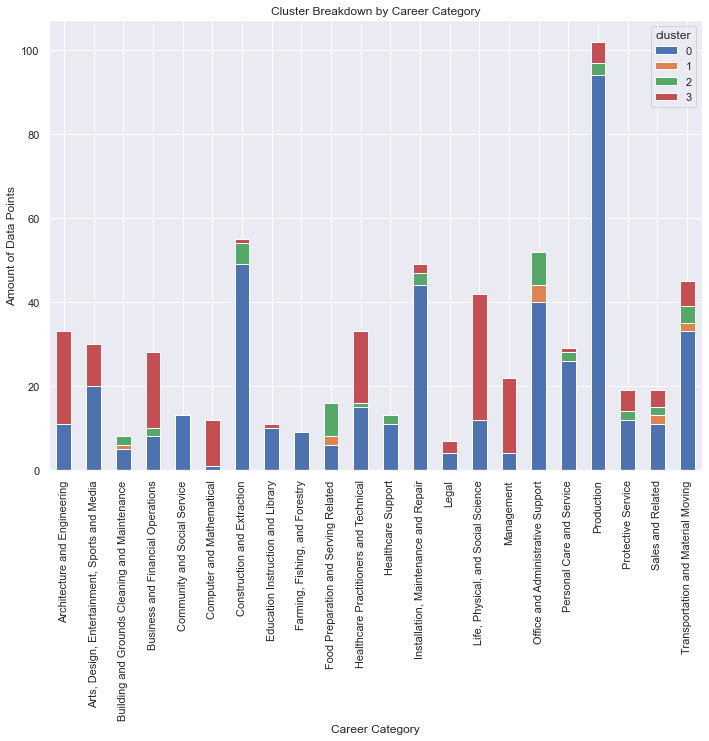

In [79]:
df2.plot(kind='bar',stacked=True)
plt.title('Cluster Breakdown by Career Category')
plt.ylabel('Amount of Data Points')
plt.xlabel('Career Category')

By visualizing the cluster data table in a stacked bar graph, we can easily see the overall number of data points that fit in each career category, as well as the breakdown of clusters for each career category. Diving deeper into the data, it appears that career categories containing some points in cluster 2 have a higher chance of automation than career categories without points in cluster 2. Visualizing clustering in this way allows us to see similarities and differences between the dataset's career categories, as well as identify outliers.